<a href="https://colab.research.google.com/github/mlacasa/EstadisticaQ2/blob/main/Anova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio Práctico: Análisis de Varianza (ANOVA) con Python

---
### **Información de la Asignatura**
* **Denominación:** Herramientas para el Análisis Bioestadístico: Técnicas Multivariantes y Validez de las Pruebas Diagnósticas
* **Máster:** Máster Universitario en Metodología de la Investigación en Ciencias de la Salud
* **Materia:** Bioestadística Sanitaria
* **Tema:** Análisis de Varianza (ANOVA)
* **Carácter:** Obligatoria | **Créditos ECTS:** 6 | **Cuatrimestre:** Segundo
---

## 1. Introducción al Ejercicio

¡Bienvenido/a a este laboratorio práctico! El objetivo de esta actividad es aplicar los conocimientos teóricos sobre el **Análisis de Varianza (ANOVA)** utilizando Python en un entorno interactivo como Google Colab.

A través de un ejemplo guiado **paso a paso**, aprenderás a preparar un conjunto de datos, realizar el análisis estadístico correspondiente y, lo más importante, interpretar los resultados en un contexto de investigación en ciencias de la salud.

## 2. 🚀 Uso de IA Generativa para Potenciar tu Aprendizaje

Para enriquecer tu experiencia y fomentar una exploración más autónoma y creativa, te recomendamos encarecidamente utilizar herramientas de **IA generativa como Gemini**. Estas herramientas son excelentes asistentes para:

* **Generar Datasets de Ejemplo**: Puedes pedirle a Gemini que cree conjuntos de datos simulados sobre diferentes escenarios clínicos para probar tus análisis.
    * *Ejemplo de prompt para Gemini*: `"Genera un DataFrame de pandas con datos de 60 pacientes distribuidos en 3 grupos (Tratamiento A, Tratamiento B, Placebo). Incluye una columna 'mejora_clinica' con valores de 1 a 100, asegurando que los datos no sigan una distribución normal."*
* **Explicar Código**: Si una línea o función de Python no te queda clara, puedes pedirle que te la explique en términos sencillos.
* **Proponer Variaciones del Ejercicio**: Pídele que te sugiera cómo modificar el ejercicio, por ejemplo, añadiendo más grupos, probando un test post-hoc diferente o creando visualizaciones más avanzadas.

El uso de estas herramientas te permitirá no solo completar el ejercicio, sino también experimentar y profundizar en los conceptos de una manera moderna y eficiente.

**¡Empecemos con el análisis!**

In [3]:
!pip install pingouin

3. Análisis Exploratorio de Datos (EDA) y Comprobación de Supuestos
Antes de realizar un test ANOVA, es fundamental realizar un análisis exploratorio de los datos para entender su estructura y comprobar si se cumplen los supuestos del test, como la normalidad.

3.1 Simulación de Datos
Primero, creamos un conjunto de datos simulado utilizando la librería pandas. Este DataFrame representará los resultados de un ensayo clínico con tres grupos de tratamiento (A, B y C), cada uno con 50 pacientes.

## Generamos los datos de ejemplo

In [4]:
import pandas as pd
import pingouin as pg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Crear un DataFrame con datos simulados
data = {
    'Tratamiento': ['A'] * 50 + ['B'] * 50 + ['C'] * 50,
    'Resultado': np.concatenate([
        np.random.normal(loc=85, scale=5, size=50),  # Grupo A
        np.random.normal(loc=78, scale=5, size=50),  # Grupo B
        np.random.normal(loc=90, scale=5, size=50)   # Grupo C
    ])
}

df = pd.DataFrame(data)
df.head()

,Tratamiento,Resultado
0,A,80.587365
1,A,90.797781
2,A,89.918061
3,A,85.274585
4,A,82.804514


3.2 Análisis Descriptivo y Prueba de Normalidad
Ahora, calculamos las estadísticas descriptivas básicas (tamaño de la muestra, media y desviación típica) para cada grupo. Además, realizamos la prueba de normalidad de Kolmogorov-Smirnov (K-S) para cada grupo.

Interpretación del p-valor (K-S): La hipótesis nula (H_0) de este test es que los datos sí siguen una distribución normal. Por lo tanto, si el p-valor es mayor que 0.05, no tenemos evidencia suficiente para rechazar la normalidad.

In [5]:
import pandas as pd
import numpy as np
from scipy import stats

# Agrupar los datos por tratamiento y calcular resultados en un solo paso
results_df = df.groupby('Tratamiento')['Resultado'].agg(
    N='count',
    Media='mean',
    Desviación_Típica='std'
).reset_index()

# Calcular el p-value del test K-S para cada grupo
results_df['p-value (K-S)'] = df.groupby('Tratamiento')['Resultado'].apply(
    lambda group: stats.kstest(group, 'norm').pvalue
).values

# Formatear p-value a 5 decimales
results_df['p-value (K-S)'] = results_df['p-value (K-S)'].apply(lambda x: f'{x:.5f}')

# Imprimir la tabla final
print(results_df)

  Tratamiento   N      Media  Desviación_Típica p-value (K-S)
0           A  50  84.390484           4.340737       0.00000
1           B  50  76.748748           5.622902       0.00000
2           C  50  89.222512           4.576167       0.00000


## Analizamos los datos

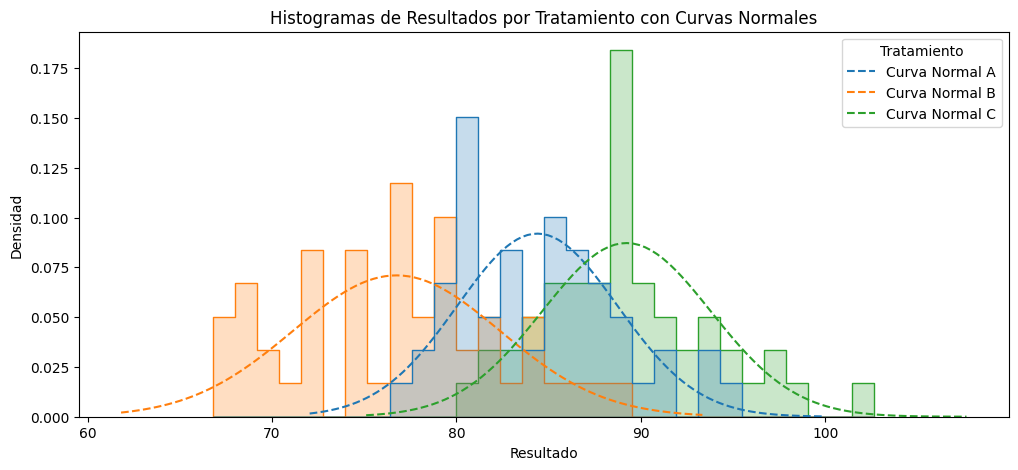

In [6]:
# Histogramas
plt.figure(figsize=(12, 5))
sns.histplot(df, x='Resultado', hue='Tratamiento', element='step', stat='density', common_norm=False, bins=30)

# Para cada tratamiento, calcular y dibujar la curva normal
for tratamiento in df['Tratamiento'].unique():
    subset = df[df['Tratamiento'] == tratamiento]
    # Calcular parámetros de la distribución normal
    mean = subset['Resultado'].mean()
    std = subset['Resultado'].std()

    # Crear un rango para la curva
    x = np.linspace(subset['Resultado'].min() - 5, subset['Resultado'].max() + 5, 100)
    y = stats.norm.pdf(x, mean, std)

    # Dibujar la curva normal
    plt.plot(x, y, label=f'Curva Normal {tratamiento}', linestyle='--')

plt.title('Histogramas de Resultados por Tratamiento con Curvas Normales')
plt.xlabel('Resultado')
plt.ylabel('Densidad')
plt.legend(title='Tratamiento')
plt.show()

## Nos ayudamos de los gráficos BoxPlot

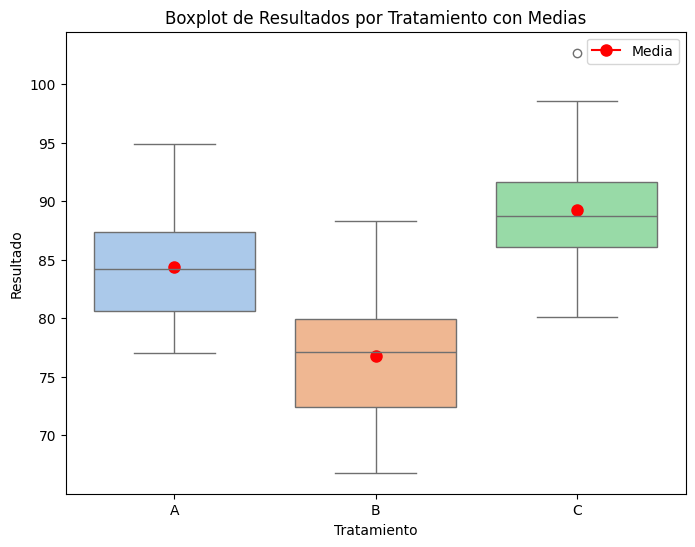

In [7]:
# Paso 3: Gráfico boxplot mejorado
plt.figure(figsize=(8, 6))

# Crear el boxplot con un paleta de colores personalizada
sns.boxplot(x = 'Tratamiento', hue='Tratamiento', y='Resultado', data=df, palette='pastel')

# Calcular y agregar la media para cada grupo
means = df.groupby('Tratamiento')['Resultado'].mean().values
for i, mean in enumerate(means):
    plt.plot(i, mean, marker='o', color='red', markersize=8, label='Media' if i == 0 else "")

# Configurar aspectos del gráfico
plt.title('Boxplot de Resultados por Tratamiento con Medias')
plt.xlabel('Tratamiento')
plt.ylabel('Resultado')

# Añadir leyenda
plt.legend()
plt.show()

4. 🚀 Desafío Opcional: Replicar con Gemini
Ahora que has visto el proceso, te animamos a que uses una herramienta de IA generativa para replicarlo y experimentar.

Prueba este prompt en Gemini:

"Usando Python y las librerías pandas y seaborn, genera un DataFrame simulado con datos de 100 pacientes divididos en 4 grupos de tratamiento. La variable de resultado debe tener una distribución no normal. Luego, genera un boxplot para comparar los 4 grupos y calcula las estadísticas descriptivas básicas (N, media, mediana, desviación típica) para cada uno."

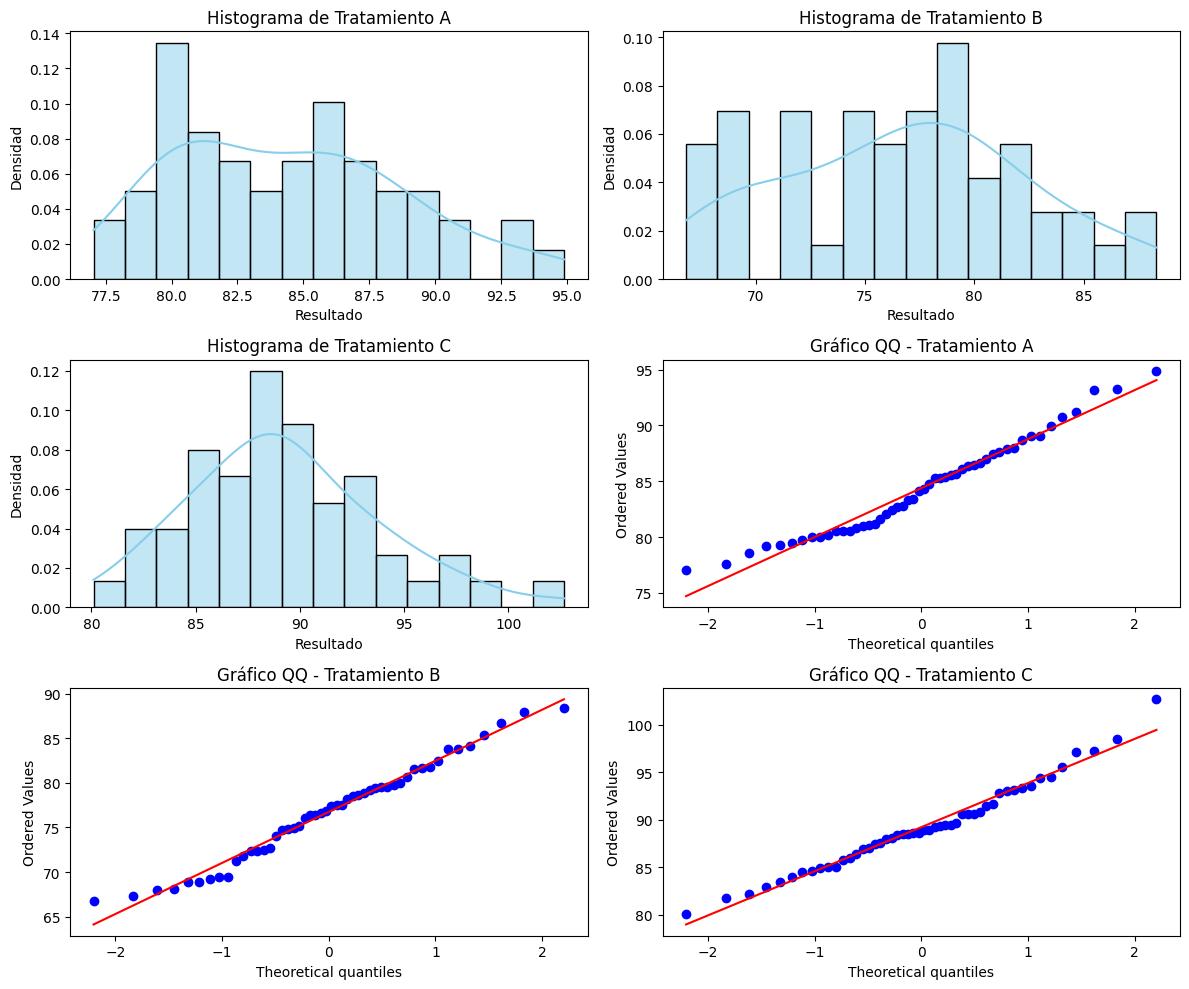

In [8]:
# Paso 4: Pruebas de Normalidad y Gráficos QQ
plt.figure(figsize=(12, 10))
for i, tratamiento in enumerate(df['Tratamiento'].unique(), start=1):
    # Histograma
    plt.subplot(3, 2, i)
    sns.histplot(df[df['Tratamiento'] == tratamiento]['Resultado'], bins=15, kde=True, stat='density', color='skyblue')
    plt.title(f'Histograma de Tratamiento {tratamiento}')
    plt.xlabel('Resultado')
    plt.ylabel('Densidad')

    # Gráfico QQ
    plt.subplot(3, 2, i + 3)
    stats.probplot(df[df['Tratamiento'] == tratamiento]['Resultado'], dist="norm", plot=plt)
    plt.title(f'Gráfico QQ - Tratamiento {tratamiento}')

plt.tight_layout()
plt.show()

In [9]:
# Paso 5: Realizar Pruebas de Normalidad (Shapiro-Wilk)
normality_results = pg.normality(df, dv='Resultado', group='Tratamiento')
print("Resultados de la Prueba de Normalidad")
print(normality_results)

Resultados de la Prueba de Normalidad
                    W      pval  normal
Tratamiento                            
A            0.965360  0.148994    True
B            0.975430  0.378959    True
C            0.978636  0.495980    True


## ANÁLISIS DE LA HOMOCEDASTICIDAD DE LAS MUESTRAS

In [ ]:
# Paso 6: Prueba de Homocedasticidad (Levene)
homoscedasticity = pg.homoscedasticity(df, dv='Resultado', group='Tratamiento')
print("\nResultados de la Prueba de Homocedasticidad")
print(homoscedasticity)

## CÁLCULO ANOVA

In [11]:
# Se ejecuta el código Python para el análisis
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- 1. Realización del Test ANOVA ---
# Se utilizan los grupos de datos que ya habíamos separado en el paso anterior
f_statistic, anova_p_value = stats.f_oneway(df['Resultado'][df['Tratamiento'] == 'A'],
                                           df['Resultado'][df['Tratamiento'] == 'B'],
                                           df['Resultado'][df['Tratamiento'] == 'C'])


print("--- Resultados del Test ANOVA ---")
print(f"Estadístico F: {f_statistic:.4f}")
print(f"P-valor: {anova_p_value:.4f}")

# --- 2. Interpretación del ANOVA y ejecución del Test Post-Hoc si es necesario ---
if anova_p_value < 0.05:
    print("\nInterpretación ANOVA: El p-valor es menor que 0.05. Se rechaza la hipótesis nula.")
    print("Existe una diferencia estadísticamente significativa entre las medias de los grupos.")
    print("\n--- Realizando Análisis Post-Hoc (HSD de Tukey) ---")

    # Realizar el test de Tukey HSD para comparaciones por pares
    tukey_results = pairwise_tukeyhsd(endog=df['Resultado'],  # Variable dependiente
                                      groups=df['Tratamiento'], # Grupos
                                      alpha=0.05)              # Nivel de significancia

    # Mostrar los resultados
    print(tukey_results)
else:
    print("\nInterpretación ANOVA: El p-valor es mayor que 0.05. No se rechaza la hipótesis nula.")
    print("No existe una diferencia estadísticamente significativa entre las medias de los grupos.")

--- Resultados del Test ANOVA ---
Estadístico F: 83.1017
P-valor: 0.0000

Interpretación ANOVA: El p-valor es menor que 0.05. Se rechaza la hipótesis nula.
Existe una diferencia estadísticamente significativa entre las medias de los grupos.

--- Realizando Análisis Post-Hoc (HSD de Tukey) ---
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     A      B  -7.6417   0.0 -9.9519 -5.3316   True
     A      C    4.832   0.0  2.5219  7.1422   True
     B      C  12.4738   0.0 10.1636 14.7839   True
---------------------------------------------------


--- Generando Gráfico de Barras con Intervalos de Confianza ---


/tmp/ipython-input-14-3688806662.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Tratamiento')


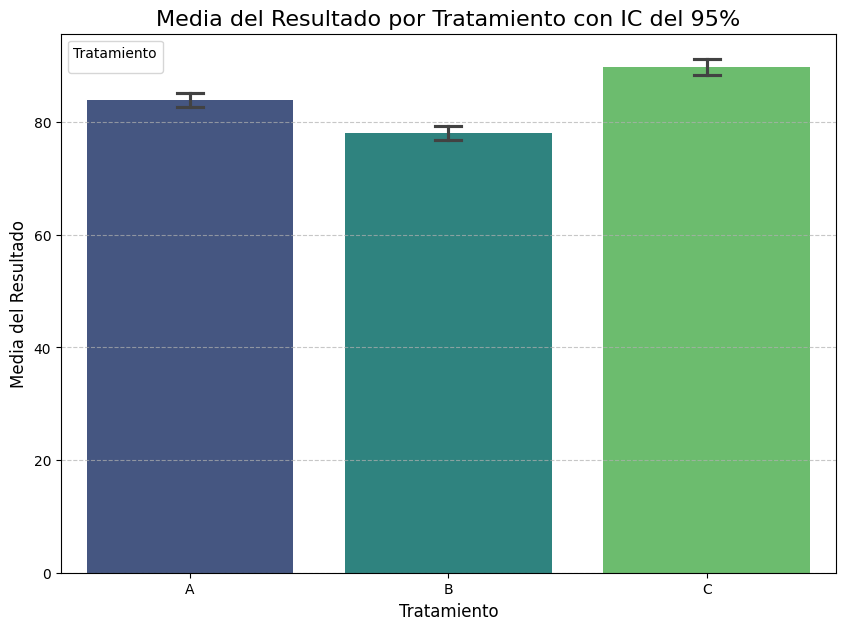

In [14]:
# Se ejecuta el código Python para la visualización
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 0. Preparación: Regenerar Datos y Resultados ---
# Para asegurar que esta celda se pueda ejecutar de forma independiente,
# volvemos a generar los datos y a calcular los resultados del ANOVA y Tukey.
np.random.seed(42)
data = {
    'Tratamiento': ['A'] * 50 + ['B'] * 50 + ['C'] * 50,
    'Resultado': np.concatenate([
        np.random.normal(loc=85, scale=5, size=50),
        np.random.normal(loc=78, scale=5, size=50),
        np.random.normal(loc=90, scale=5, size=50)
    ])
}
df = pd.DataFrame(data)

# Realizar el test de Tukey HSD
tukey_results = pairwise_tukeyhsd(endog=df['Resultado'],
                                  groups=df['Tratamiento'],
                                  alpha=0.05)

# --- 1. Gráfico de Barras con Intervalos de Confianza ---
print("--- Generando Gráfico de Barras con Intervalos de Confianza ---")
plt.figure(figsize=(10, 7))

# Seaborn calcula automáticamente la media y el intervalo de confianza del 95%
sns.barplot(x='Tratamiento', y='Resultado', data=df, hue='Tratamiento', palette='viridis', capsize=0.1, errorbar='ci')

plt.title('Media del Resultado por Tratamiento con IC del 95%', fontsize=16)
plt.xlabel('Tratamiento', fontsize=12)
plt.ylabel('Media del Resultado', fontsize=12)
plt.legend(title='Tratamiento')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()





--- Generando Gráfico de Resultados del Test de Tukey HSD ---


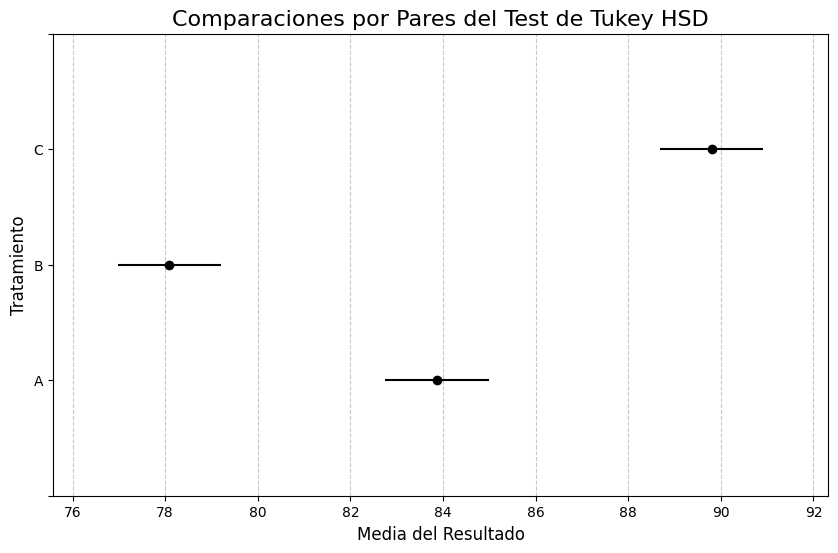

In [15]:
# --- 2. Gráfico de Comparaciones Múltiples de Tukey HSD ---
print("\n--- Generando Gráfico de Resultados del Test de Tukey HSD ---")

# La función plot_simultaneous del objeto de resultados de Tukey crea el gráfico.
# Muestra el intervalo de confianza del 95% para la media de cada grupo.
fig = tukey_results.plot_simultaneous()
plt.title('Comparaciones por Pares del Test de Tukey HSD', fontsize=16)
plt.xlabel('Media del Resultado', fontsize=12)
plt.ylabel('Tratamiento', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ANOVA DATOS PAREADOS

In [16]:
# Definir número de pacientes por grupo
num_pacientes_por_grupo = 50
grupos = ['A', 'B', 'C']

# Crear el DataFrame simulado
data = {
    'Edad': np.random.randint(30, 70, size=num_pacientes_por_grupo * len(grupos)),  # Edades entre 30 y 70
    'Sexo': np.random.choice(['Masculino', 'Femenino'], size=num_pacientes_por_grupo * len(grupos)),  # Sexo
    'Tratamiento': np.repeat(grupos, num_pacientes_por_grupo),  # Tratamiento A, B y C
}

# Convertir a DataFrame
df = pd.DataFrame(data)

# Simular los niveles de colesterol inicial y final para cada tratamiento
# Supongamos que los niveles de colesterol son distintos según el tratamiento
df['Colesterol_Inicial'] = np.concatenate([
    np.random.normal(loc=220, scale=15, size=num_pacientes_por_grupo),  # Tratamiento A
    np.random.normal(loc=230, scale=15, size=num_pacientes_por_grupo),  # Tratamiento B
    np.random.normal(loc=215, scale=15, size=num_pacientes_por_grupo)   # Tratamiento C
])

# Simular una reducción en colesterol después de 8 semanas de tratamiento
# Supongamos que el efecto del tratamiento varía
df['Colesterol_Final'] = df['Colesterol_Inicial'] - np.concatenate([
    np.random.randint(15, 30, size=num_pacientes_por_grupo),  # Tratamiento A
    np.random.randint(10, 25, size=num_pacientes_por_grupo),  # Tratamiento B
    np.random.randint(20, 35, size=num_pacientes_por_grupo)   # Tratamiento C
])
df.head()

,Edad,Sexo,Tratamiento,Colesterol_Inicial,Colesterol_Final
0,53,Femenino,A,211.155207,195.155207
1,62,Femenino,A,215.525482,188.525482
2,53,Masculino,A,213.830641,189.830641
3,40,Masculino,A,234.760353,217.760353
4,37,Femenino,A,221.553521,204.553521


--- Prueba de Chi-Cuadrado para el Balance de Sexo ---
Tabla de Contingencia (Frecuencias):
Sexo         Femenino  Masculino
Tratamiento                     
A                  23         27
B                  27         23
C                  24         26

Resultados del Test:
Estadístico Chi-cuadrado: 0.6935
P-valor: 0.7070
Interpretación: El p-valor > 0.05. No hay evidencia de un desbalanceo significativo de sexo entre los grupos.


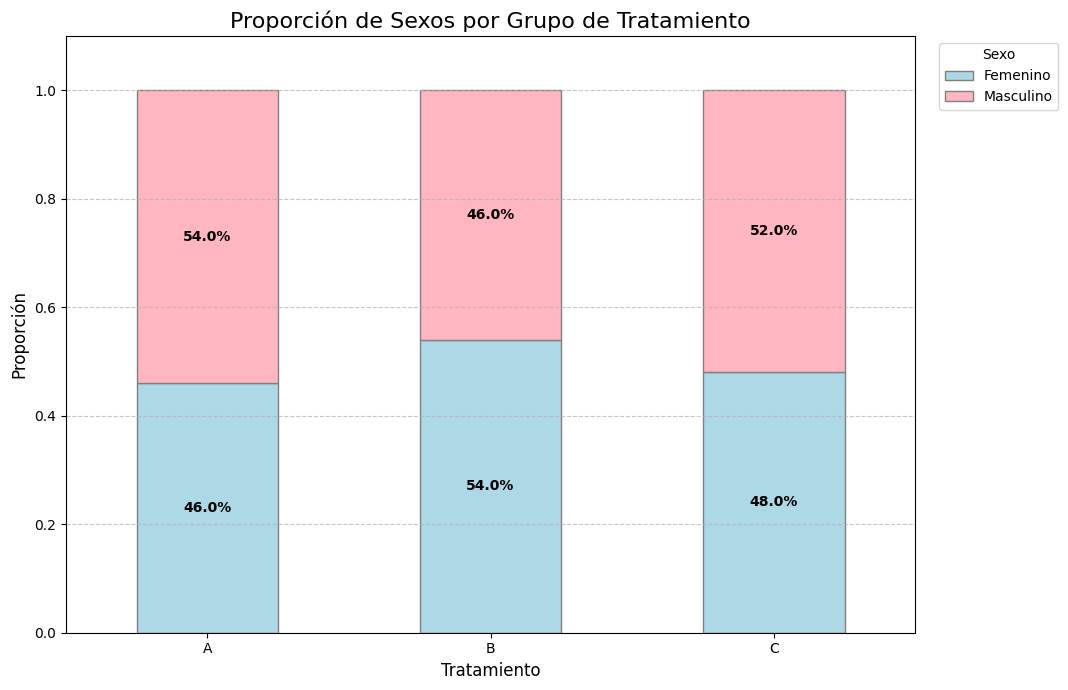

In [18]:
# Se ejecuta el código Python para el análisis de balanceo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# --- 0. Generación de Datos ---
# Se regeneran los datos para que la celda sea autónoma.
np.random.seed(42) # Para reproducibilidad
num_pacientes_por_grupo = 50
grupos = ['A', 'B', 'C']

data = {
    'Edad': np.random.randint(30, 70, size=num_pacientes_por_grupo * len(grupos)),
    'Sexo': np.random.choice(['Masculino', 'Femenino'], size=num_pacientes_por_grupo * len(grupos)),
    'Tratamiento': np.repeat(grupos, num_pacientes_por_grupo),
}
df = pd.DataFrame(data)

# --- 1. Test Estadístico de Chi-cuadrado ---
# Crear una tabla de contingencia con las frecuencias (conteos)
contingency_table = pd.crosstab(df['Tratamiento'], df['Sexo'])

# Realizar la prueba de Chi-cuadrado
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("--- Prueba de Chi-Cuadrado para el Balance de Sexo ---")
print("Tabla de Contingencia (Frecuencias):")
print(contingency_table)
print("\nResultados del Test:")
print(f"Estadístico Chi-cuadrado: {chi2:.4f}")
print(f"P-valor: {p_value:.4f}")

if p_value > 0.05:
    print("Interpretación: El p-valor > 0.05. No hay evidencia de un desbalanceo significativo de sexo entre los grupos.")
else:
    print("Interpretación: El p-valor <= 0.05. Existe un desbalanceo significativo de sexo entre los grupos.")


# --- 2. Visualización Mejorada con Anotaciones ---
# Calcular las proporciones para el gráfico
proporciones = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Graficar
ax = proporciones.plot(kind='bar', stacked=True, color=['lightblue', 'lightpink'], figsize=(12, 7), edgecolor='grey')

# Añadir anotaciones (porcentajes) en cada barra
for container in ax.containers:
    # La función 'bar_label' formatea y coloca las etiquetas
    ax.bar_label(container, labels=[f'{v:.1%}' for v in container.datavalues], label_type='center', fontsize=10, color='black', weight='bold')

plt.title('Proporción de Sexos por Grupo de Tratamiento', fontsize=16)
plt.xlabel('Tratamiento', fontsize=12)
plt.ylabel('Proporción', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Sexo', bbox_to_anchor=(1.02, 1), loc='upper left') # Mover leyenda fuera del gráfico
plt.ylim(0, 1.1) # Ajustar el límite del eje Y para dar espacio a la leyenda
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Ajustar layout para que la leyenda no se corte
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Analizamos si existen diferencias significativas

--- Paso 1: Tabla de Contingencia (Frecuencias Observadas) ---
Sexo         Femenino  Masculino
Tratamiento                     
A                  27         23
B                  29         21
C                  26         24

Esta tabla muestra cuántos hombres y mujeres hay en cada grupo de tratamiento.

--- Paso 2: Resultados del Test Chi-Cuadrado ---
Valor del estadístico Chi-cuadrado: 0.3766
Grados de libertad (dof): 2
P-valor: 0.8284

--- Paso 3: Interpretación del P-valor ---
El p-valor (0.8284) es mayor que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.
Conclusión: No hay evidencia de una asociación significativa entre el grupo de tratamiento y el sexo.

--- Paso 4: Visualización de la Tabla de Contingencia ---


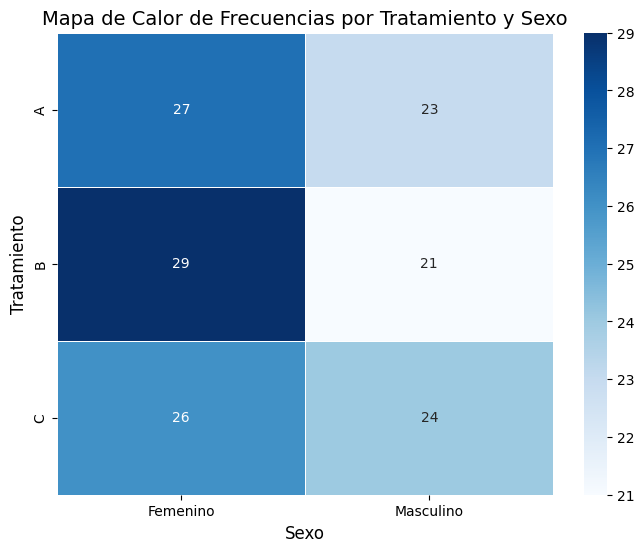

In [20]:
# Se ejecuta el código Python para el análisis de balanceo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# --- 0. Generación de Datos ---
# Se regeneran los datos para que la celda sea autónoma.
np.random.seed(42)
num_pacientes_por_grupo = 50
grupos = ['A', 'B', 'C']
df = pd.DataFrame({
    'Sexo': np.random.choice(['Masculino', 'Femenino'], size=num_pacientes_por_grupo * len(grupos)),
    'Tratamiento': np.repeat(grupos, num_pacientes_por_grupo),
})

# --- Paso 1: Crear y Explicar la Tabla de Contingencia ---
# Una tabla de contingencia muestra la frecuencia de cada combinación de categorías.
# Es la base para el test de Chi-cuadrado. La creamos sin los totales para el cálculo.
print("--- Paso 1: Tabla de Contingencia (Frecuencias Observadas) ---")
tabla_contingencia = pd.crosstab(df['Tratamiento'], df['Sexo'])
print(tabla_contingencia)
print("\nEsta tabla muestra cuántos hombres y mujeres hay en cada grupo de tratamiento.")

# --- Paso 2: Realizar la Prueba Chi-cuadrado de Independencia ---
# Este test nos dice si la asociación observada entre las variables es estadísticamente significativa.
# Hipótesis Nula (H₀): No hay asociación entre el Tratamiento y el Sexo (son independientes).
# Hipótesis Alternativa (H₁): Sí hay una asociación entre el Tratamiento y el Sexo.
chi2, p_valor, dof, frec_esperadas = chi2_contingency(tabla_contingencia)

print("\n--- Paso 2: Resultados del Test Chi-Cuadrado ---")
print(f"Valor del estadístico Chi-cuadrado: {chi2:.4f}")
print(f"Grados de libertad (dof): {dof}")
print(f"P-valor: {p_valor:.4f}")

# --- Paso 3: Interpretación del Resultado ---
print("\n--- Paso 3: Interpretación del P-valor ---")
alpha = 0.05
if p_valor < alpha:
    print(f"El p-valor ({p_valor:.4f}) es menor que {alpha}, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: Existe una asociación estadísticamente significativa entre el grupo de tratamiento y el sexo.")
else:
    print(f"El p-valor ({p_valor:.4f}) es mayor que {alpha}, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: No hay evidencia de una asociación significativa entre el grupo de tratamiento y el sexo.")

# --- Paso 4: Visualización con un Mapa de Calor (Heatmap) ---
# Un mapa de calor ayuda a visualizar las frecuencias de la tabla de contingencia de forma intuitiva.
# Los colores más intensos indican frecuencias más altas.
print("\n--- Paso 4: Visualización de la Tabla de Contingencia ---")
plt.figure(figsize=(8, 6))
sns.heatmap(tabla_contingencia, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=True)
plt.title('Mapa de Calor de Frecuencias por Tratamiento y Sexo', fontsize=14)
plt.xlabel('Sexo', fontsize=12)
plt.ylabel('Tratamiento', fontsize=12)
plt.show()

In [21]:
# --- Interpretación Final del Resultado ---

alpha = 0.05
# La variable 'p' contiene el p-valor calculado en el paso anterior.

if p < alpha:
    print(f"**Conclusión: Se rechaza la hipótesis nula (H0).**")
    print(f"\nEl p-valor ({p:.4f}) es menor que {alpha}, lo que indica una **asociación estadísticamente significativa** entre el tipo de tratamiento y el sexo de los participantes.")
    print("\n**Implicación Práctica:** Los grupos de tratamiento **NO están balanceados** con respecto al sexo. La proporción de hombres y mujeres es diferente en al menos uno de los grupos, un factor que debería considerarse en análisis posteriores.")
else:
    print(f"**Conclusión: No se puede rechazar la hipótesis nula (H0).**")
    print(f"\nEl p-valor ({p:.4f}) es mayor que {alpha}, lo que sugiere que **no hay evidencia de una asociación** entre el tipo de tratamiento y el sexo.")
    print("\n**Implicación Práctica:** Los grupos de tratamiento se consideran **balanceados** con respecto al sexo. Las diferencias observadas en las proporciones se deben probablemente al azar.")

**Conclusión: No se puede rechazar la hipótesis nula (H0).**

El p-valor (0.7070) es mayor que 0.05, lo que sugiere que **no hay evidencia de una asociación** entre el tipo de tratamiento y el sexo.

**Implicación Práctica:** Los grupos de tratamiento se consideran **balanceados** con respecto al sexo. Las diferencias observadas en las proporciones se deben probablemente al azar.


## UN ANÁLISIS VISUAL

Se genera un gráfico para evaluar si hubieran diferencias entre los resultados del tratamiento según sexo, y se observa que pudiera haberlos en el grupo C.

/tmp/ipython-input-23-3115180306.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Grupo A', 'Grupo B', 'Grupo C'],


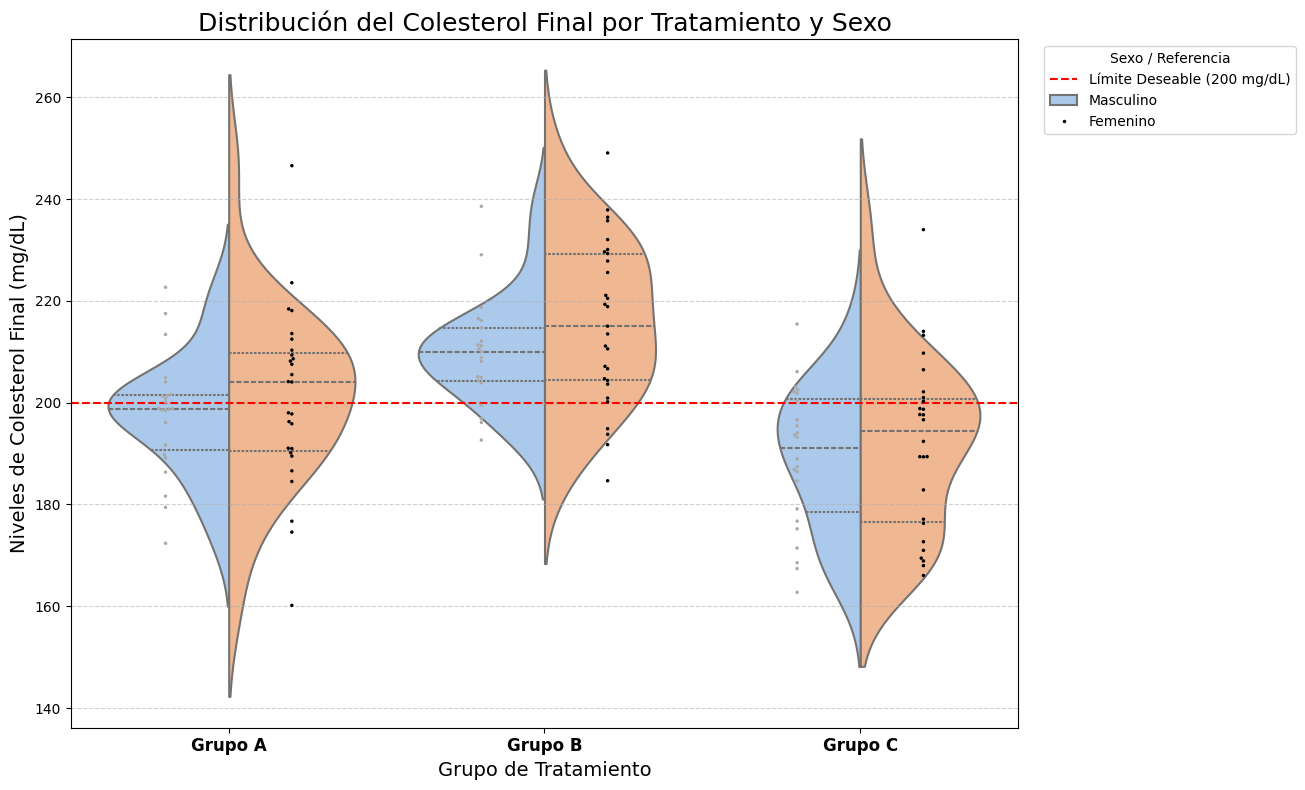

In [23]:
# Se ejecuta el código Python para la visualización final
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. Generación de Datos ---
# Se regeneran los datos para que la celda sea autónoma.
np.random.seed(42) # Para reproducibilidad
num_pacientes_por_grupo = 50
grupos = ['A', 'B', 'C']
df = pd.DataFrame({
    'Sexo': np.random.choice(['Masculino', 'Femenino'], size=num_pacientes_por_grupo * len(grupos)),
    'Tratamiento': np.repeat(grupos, num_pacientes_por_grupo),
})
df['Colesterol_Inicial'] = np.concatenate([
    np.random.normal(loc=220, scale=15, size=num_pacientes_por_grupo),
    np.random.normal(loc=230, scale=15, size=num_pacientes_por_grupo),
    np.random.normal(loc=215, scale=15, size=num_pacientes_por_grupo)
])
df['Colesterol_Final'] = df['Colesterol_Inicial'] - np.concatenate([
    np.random.randint(15, 30, size=num_pacientes_por_grupo),
    np.random.randint(10, 25, size=num_pacientes_por_grupo),
    np.random.randint(20, 35, size=num_pacientes_por_grupo)
])


# --- 1. Creación del Gráfico de Violín Mejorado ---
plt.figure(figsize=(15, 8))

# Dibuja una línea horizontal para el umbral clínico de colesterol (200 mg/dL)
plt.axhline(y=200, color='red', linestyle='--', linewidth=1.5, label='Límite Deseable (200 mg/dL)')

# Crear el gráfico de violín
sns.violinplot(x='Tratamiento', y='Colesterol_Final', hue='Sexo', data=df,
               split=True, palette='pastel', inner='quartile', linewidth=1.5)

# Superponer un swarmplot para mostrar los puntos de datos individuales
sns.swarmplot(x='Tratamiento', y='Colesterol_Final', hue='Sexo', data=df,
              dodge=True,
              size=2.5,
              # Se usa 'palette' para asignar el color y evitar advertencias
              palette={'Masculino': 'darkgray', 'Femenino': 'black'})


# --- 2. Mejora y Configuración de Títulos y Ejes ---
plt.title('Distribución del Colesterol Final por Tratamiento y Sexo', fontsize=18)
plt.xlabel('Grupo de Tratamiento', fontsize=14) # Etiqueta del eje X más descriptiva
plt.ylabel('Niveles de Colesterol Final (mg/dL)', fontsize=14)

# --- MEJORA: Personalizar las etiquetas del eje X para que sean más visuales ---
ax = plt.gca()
ax.set_xticklabels(['Grupo A', 'Grupo B', 'Grupo C'],
                   fontweight='bold',
                   fontsize=12)


# --- 3. Configuración Final de la Leyenda y el Gráfico ---
handles, labels = plt.gca().get_legend_handles_labels()
# El swarmplot duplica las etiquetas, así que tomamos solo las necesarias y añadimos la de la línea roja.
unique_labels_index = [0, 1]
plt.legend([handles[i] for i in unique_labels_index] + [handles[-1]],
           [labels[i] for i in unique_labels_index] + [labels[-1]],
           title='Sexo / Referencia', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.88, 1]) # Ajustar para que la leyenda no se corte
plt.show()

## 🚀 Desafío Final: Consolida tu Aprendizaje con IA Generativa

¡Excelente trabajo! Has llegado al final de este ejercicio práctico. Ahora es tu turno de poner a prueba tus habilidades de una manera moderna y muy potente.

El verdadero aprendizaje en programación y análisis de datos no consiste en memorizar código, sino en saber **formular las preguntas correctas** y encontrar las herramientas para responderlas. Las IAs generativas como **Gemini** son un aliado excepcional en este proceso.

Te proponemos el siguiente desafío: utiliza el prompt que te proporcionamos a continuación para pedirle a Gemini que genere, desde cero, el código del complejo gráfico que acabamos de construir. Observa cómo traduce tus instrucciones en lenguaje natural a código Python.

### Prompt para Gemini

Copia y pega el siguiente prompt en Gemini. Analiza si el código que genera es correcto y compáralo con el que hemos utilizado en este ejercicio.

> **Prompt Detallado:**
>
> Usando Python con las librerías `pandas`, `seaborn` y `matplotlib`, realiza los siguientes pasos:
>
> 1.  **Crea un DataFrame simulado** para un ensayo clínico. Debe contener 150 pacientes distribuidos equitativamente en 3 grupos de tratamiento ('A', 'B', 'C'). Incluye las variables:
>     * `Tratamiento`: El grupo asignado.
>     * `Sexo`: 'Masculino' o 'Femenino', asignado aleatoriamente.
>     * `Colesterol_Final`: Un valor numérico simulado.
>
> 2.  **Genera un gráfico de violín** para visualizar la distribución del `Colesterol_Final` por `Tratamiento` y `Sexo`. El gráfico debe tener las siguientes características específicas:
>     * Cada violín debe estar **dividido por la mitad** para mostrar la distribución de cada `Sexo` (`split=True`).
>     * Dentro de cada violín, deben mostrarse **líneas para los cuartiles** (`inner='quartile'`).
>     * Superpón los **puntos de datos individuales** en el gráfico usando un `swarmplot`. Los puntos deben estar separados por sexo para que coincidan con el violín (`dodge=True`).
>     * Añade una **línea de referencia horizontal y discontinua** en el valor 200 para representar un umbral clínico.
>     * Personaliza el gráfico con un título claro, etiquetas descriptivas para los ejes X e Y, y una leyenda que identifique los colores y la línea de referencia.

Experimentar con este tipo de prompts te ayudará a desarrollar una de las habilidades más importantes para un investigador moderno: saber cómo **comunicar un problema analítico complejo** para obtener una solución de manera eficiente.

# ANOVA EVALUAR SI LA EDAD TIENE DIFERENCIAS ENTRE GRUPOS

--- Paso 1: Comprobación de Supuestos ---
Resultados del Test de Normalidad (Shapiro-Wilk):
                         W      pval  normal
Tratamiento                                 
A           Edad  0.956742  0.064937    True
B           Edad  0.940460  0.014050   False
C           Edad  0.931762  0.006447   False

Resultados del Test de Homocedasticidad (Levene):
               W      pval  equal_var
levene  0.311209  0.733042       True

Interpretación de supuestos: Si los p-valores de ambos tests son > 0.05, los supuestos se cumplen.

--- Paso 2: Resultados del ANOVA de Edad por Grupo ---
        Source            SS   DF          MS         F     p-unc       np2
0  Tratamiento    384.813333    2  192.406667  1.400807  0.249667  0.018702
1       Within  20191.060000  147  137.354150       NaN       NaN       NaN

--- Paso 3: Interpretación del Resultado ---
Conclusión: No se puede rechazar la H0 (p-valor = 0.2497).
No hay diferencias significativas en la edad media entre los grupos

/tmp/ipython-input-25-2220426514.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normality_results = df.groupby('Tratamiento').apply(lambda x: pg.normality(x['Edad']))


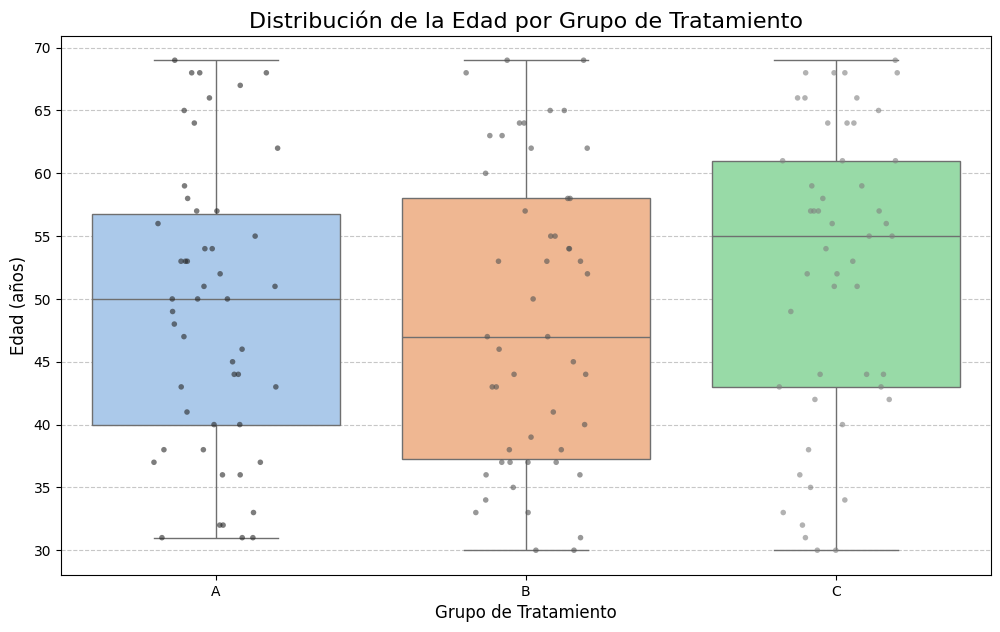

In [25]:
# Se ejecuta el código Python para el análisis de balanceo de edad
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- 0. Generación de Datos ---
# Se regeneran los datos para que la celda sea autónoma.
np.random.seed(42) # Para reproducibilidad
num_pacientes_por_grupo = 50
grupos = ['A', 'B', 'C']
df = pd.DataFrame({
    'Edad': np.random.randint(30, 70, size=num_pacientes_por_grupo * len(grupos)),
    'Tratamiento': np.repeat(grupos, num_pacientes_por_grupo),
})


# --- 1. Comprobación de Supuestos del ANOVA ---
print("--- Paso 1: Comprobación de Supuestos ---")
# a) Normalidad (Test de Shapiro-Wilk para cada grupo)
normality_results = df.groupby('Tratamiento').apply(lambda x: pg.normality(x['Edad']))
print("Resultados del Test de Normalidad (Shapiro-Wilk):")
print(normality_results)
# b) Homocedasticidad (Igualdad de varianzas - Test de Levene)
homoscedasticity_results = pg.homoscedasticity(data=df, dv='Edad', group='Tratamiento')
print("\nResultados del Test de Homocedasticidad (Levene):")
print(homoscedasticity_results)
print("\nInterpretación de supuestos: Si los p-valores de ambos tests son > 0.05, los supuestos se cumplen.")


# --- 2. Realización del Test ANOVA ---
# Si los supuestos se cumplen, procedemos con el ANOVA.
print("\n--- Paso 2: Resultados del ANOVA de Edad por Grupo ---")
anova_results = pg.anova(dv='Edad', between='Tratamiento', data=df, detailed=True)
print(anova_results)


# --- 3. Interpretación del Resultado del ANOVA ---
print("\n--- Paso 3: Interpretación del Resultado ---")
alpha = 0.05
p_value = anova_results['p-unc'][0]

if p_value < alpha:
    print(f"Conclusión: Se rechaza la H0 (p-valor = {p_value:.4f}).")
    print("Existe una diferencia estadísticamente significativa en la edad media entre los grupos.")
    print("Los grupos NO están bien balanceados por edad.")

    # Realizar análisis Post-Hoc de Tukey para ver qué grupos difieren
    print("\n--- Análisis Post-Hoc (Tukey HSD) ---")
    tukey = pairwise_tukeyhsd(endog=df['Edad'], groups=df['Tratamiento'], alpha=alpha)
    print(tukey)
else:
    print(f"Conclusión: No se puede rechazar la H0 (p-valor = {p_value:.4f}).")
    print("No hay diferencias significativas en la edad media entre los grupos.")
    print("Los grupos se consideran balanceados por edad.")


# --- 4. Visualización Mejorada ---
print("\n--- Paso 4: Visualización de la Distribución de Edad ---")
plt.figure(figsize=(12, 7))

# Boxplot como base para ver los cuartiles
sns.boxplot(x='Tratamiento', y='Edad', data=df, hue='Tratamiento', palette='pastel', legend=False)

# Stripplot para superponer los puntos de datos individuales
sns.stripplot(x='Tratamiento', y='Edad', data=df, hue='Tratamiento', palette='dark:grey', jitter=0.2, size=4, alpha=0.6, legend=False)

plt.title('Distribución de la Edad por Grupo de Tratamiento', fontsize=16)
plt.xlabel('Grupo de Tratamiento', fontsize=12)
plt.ylabel('Edad (años)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Y los niveles de colesterior inicial por grupos, hay diferencias significativas?

--- Paso 1: Comprobación de Supuestos para el Colesterol Inicial ---
Resultados del Test de Normalidad (Shapiro-Wilk):
                                       W      pval  normal
Tratamiento                                               
A           Colesterol_Inicial  0.982749  0.672208    True
B           Colesterol_Inicial  0.971317  0.261614    True
C           Colesterol_Inicial  0.977538  0.453432    True

Resultados del Test de Homocedasticidad (Levene):
               W      pval  equal_var
levene  0.545457  0.580746       True

Interpretación de supuestos: Para proceder con el ANOVA, los p-valores ('p-val') deben ser > 0.05.

--- Paso 2: Resultados del ANOVA para el Colesterol Inicial ---
        Source            SS   DF           MS          F         p-unc  \
0  Tratamiento   7376.261063    2  3688.130532  18.436645  7.173045e-08   
1       Within  29406.390778  147   200.043475        NaN           NaN   

        np2  
0  0.200536  
1       NaN  

--- Paso 3: Interpretació

/tmp/ipython-input-26-2673238931.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normality_results = df.groupby('Tratamiento').apply(lambda x: pg.normality(x['Colesterol_Inicial']))


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  13.6488    0.0   6.9512 20.3464   True
     A      C  -2.2072 0.7157  -8.9048  4.4904  False
     B      C  -15.856    0.0 -22.5536 -9.1585   True
-----------------------------------------------------

--- Paso 4: Visualización de la Distribución del Colesterol Inicial ---


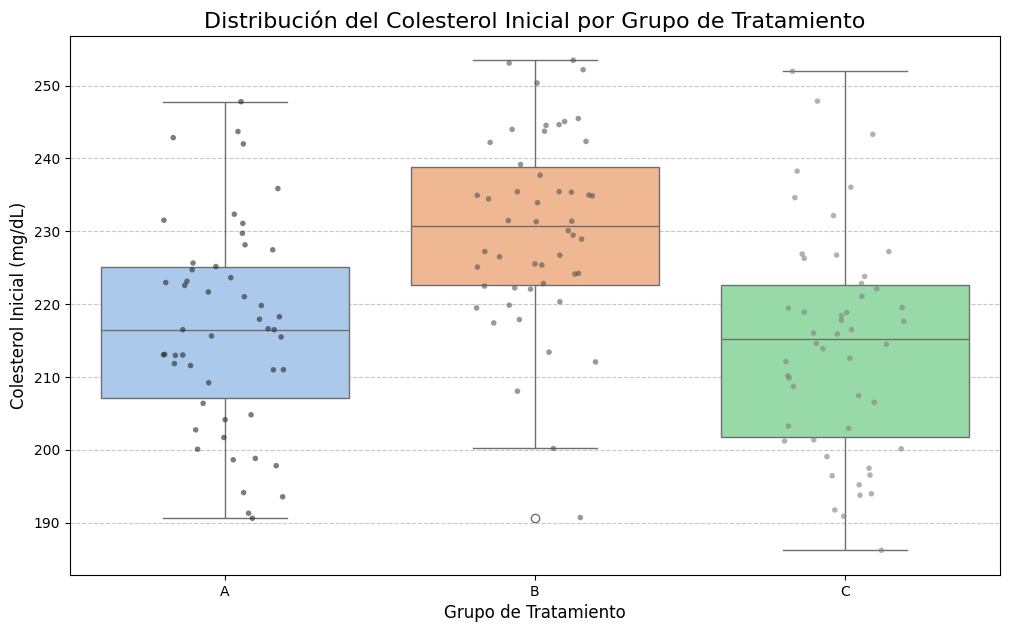

In [26]:
# Se ejecuta el código Python para el análisis de balanceo del colesterol inicial
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- 0. Generación de Datos ---
# Se regeneran los datos para que la celda sea autónoma.
np.random.seed(42)
num_pacientes_por_grupo = 50
grupos = ['A', 'B', 'C']
df = pd.DataFrame({
    'Tratamiento': np.repeat(grupos, num_pacientes_por_grupo),
})
df['Colesterol_Inicial'] = np.concatenate([
    np.random.normal(loc=220, scale=15, size=num_pacientes_por_grupo),
    np.random.normal(loc=230, scale=15, size=num_pacientes_por_grupo),
    np.random.normal(loc=215, scale=15, size=num_pacientes_por_grupo)
])


# --- 1. Comprobación de Supuestos del ANOVA ---
print("--- Paso 1: Comprobación de Supuestos para el Colesterol Inicial ---")
# a) Normalidad (Test de Shapiro-Wilk)
normality_results = df.groupby('Tratamiento').apply(lambda x: pg.normality(x['Colesterol_Inicial']))
print("Resultados del Test de Normalidad (Shapiro-Wilk):")
print(normality_results)

# b) Homocedasticidad (Test de Levene)
homoscedasticity_results = pg.homoscedasticity(data=df, dv='Colesterol_Inicial', group='Tratamiento')
print("\nResultados del Test de Homocedasticidad (Levene):")
print(homoscedasticity_results)
print("\nInterpretación de supuestos: Para proceder con el ANOVA, los p-valores ('p-val') deben ser > 0.05.")


# --- 2. Realización del Test ANOVA ---
print("\n--- Paso 2: Resultados del ANOVA para el Colesterol Inicial ---")
# Hipótesis Nula (H₀): Las medias de colesterol inicial son iguales en todos los grupos.
# Un p-valor > 0.05 es el resultado deseado, ya que indica que los grupos son comparables.
anova_results = pg.anova(dv='Colesterol_Inicial', between='Tratamiento', data=df, detailed=True)
print(anova_results)


# --- 3. Interpretación Detallada del Resultado ---
print("\n--- Paso 3: Interpretación del Resultado ---")
alpha = 0.05
p_value = anova_results['p-unc'][0]

if p_value < alpha:
    print(f"Conclusión: Se rechaza la H0 (p-valor = {p_value:.4f}).")
    print("Existe una diferencia estadísticamente significativa en el colesterol inicial entre los grupos.")
    print("Esto indica un DESBALANCEO INICIAL, lo cual es un problema para el estudio.")

    # Si hay desbalanceo, identificamos dónde está con un test Post-Hoc
    print("\n--- Análisis Post-Hoc (Tukey HSD) para identificar el desbalanceo ---")
    tukey = pairwise_tukeyhsd(endog=df['Colesterol_Inicial'], groups=df['Tratamiento'], alpha=alpha)
    print(tukey)
else:
    print(f"Conclusión: No se puede rechazar la H0 (p-valor = {p_value:.4f}).")
    print("No hay diferencias significativas en el colesterol inicial entre los grupos.")
    print("Los grupos se consideran bien BALANCEADOS al inicio del estudio.")


# --- 4. Visualización Mejorada ---
print("\n--- Paso 4: Visualización de la Distribución del Colesterol Inicial ---")
plt.figure(figsize=(12, 7))

# Boxplot como base para ver los cuartiles
sns.boxplot(x='Tratamiento', y='Colesterol_Inicial', data=df, hue='Tratamiento', palette='pastel', legend=False)

# Stripplot para superponer los puntos de datos individuales
sns.stripplot(x='Tratamiento', y='Colesterol_Inicial', data=df, hue='Tratamiento', palette='dark:grey', jitter=0.2, size=4, alpha=0.6, legend=False)

plt.title('Distribución del Colesterol Inicial por Grupo de Tratamiento', fontsize=16)
plt.xlabel('Grupo de Tratamiento', fontsize=12)
plt.ylabel('Colesterol Inicial (mg/dL)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## HEMOS DE DETALLAR ESTA DIFERENCIA

Existe el grupo B que tiene un colesterol incial significativamente más alto qeu el resto, y debe tenerse en cuenta en el posterior análisis.

## ANOVA DE DATOS PAREADOS

Ahora analizamos si hay diferencias significativas entre los niveles iniciales y finales

--- Vista Previa de los Datos en Formato Largo ---
   Paciente_ID Tratamiento              Tiempo  Colesterol
0            0           A  Colesterol_Inicial  227.450712
1            1           A  Colesterol_Inicial  217.926035
2            2           A  Colesterol_Inicial  229.715328
3            3           A  Colesterol_Inicial  242.845448
4            4           A  Colesterol_Inicial  216.487699

--- Resultados del ANOVA de Diseño Mixto ---
        Source            SS  DF1  DF2            MS            F  \
0  Tratamiento  24258.361024    2  147  12129.180512    28.828235   
1       Tiempo  34647.253333    1  147  34647.253333  3479.257743   
2  Interaction   1467.886667    2  147    733.943333    73.702178   

           p-unc       np2  eps  
0   2.738112e-11  0.281723  NaN  
1  3.191668e-104  0.959462  1.0  
2   6.767420e-23  0.500687  NaN  

--- Interpretación Detallada ---
Efecto de Interacción Significativo (p=0.0000):
El cambio en el colesterol a lo largo del tiempo DEPEN

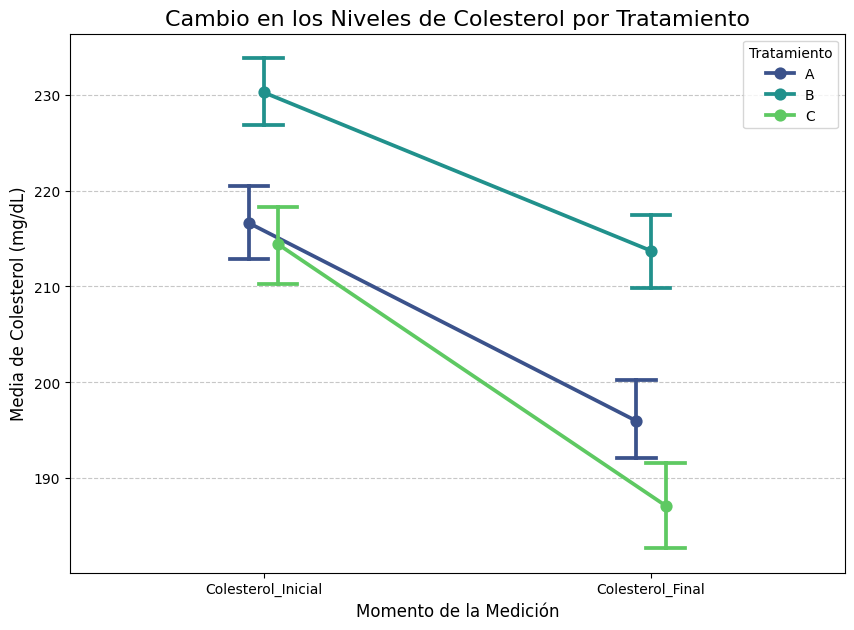

In [29]:

# Se ejecuta el código Python para el ANOVA de diseño mixto
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. Generación de Datos ---
# Se regeneran los datos para que la celda sea autónoma.
np.random.seed(42)
num_pacientes_por_grupo = 50
grupos = ['A', 'B', 'C']
total_pacientes = num_pacientes_por_grupo * len(grupos)

df = pd.DataFrame({
    'Paciente_ID': range(total_pacientes), # ID único para cada paciente
    'Tratamiento': np.repeat(grupos, num_pacientes_por_grupo),
})

df['Colesterol_Inicial'] = np.concatenate([
    np.random.normal(loc=220, scale=15, size=num_pacientes_por_grupo),
    np.random.normal(loc=230, scale=15, size=num_pacientes_por_grupo),
    np.random.normal(loc=215, scale=15, size=num_pacientes_por_grupo)
])

df['Colesterol_Final'] = df['Colesterol_Inicial'] - np.concatenate([
    np.random.randint(15, 30, size=num_pacientes_por_grupo),
    np.random.randint(10, 25, size=num_pacientes_por_grupo),
    np.random.randint(20, 35, size=num_pacientes_por_grupo)
])


# --- 1. Preparación de los Datos (Formato Largo) ---
df_long = pd.melt(df, id_vars=['Paciente_ID', 'Tratamiento'],
                  value_vars=['Colesterol_Inicial', 'Colesterol_Final'],
                  var_name='Tiempo', value_name='Colesterol')

print("--- Vista Previa de los Datos en Formato Largo ---")
print(df_long.head())


# --- 2. Realización del ANOVA de Diseño Mixto ---
# CORRECCIÓN: Se usa pg.mixed_anova() en lugar de pg.rm_anova()
print("\n--- Resultados del ANOVA de Diseño Mixto ---")
mixed_anova_results = pg.mixed_anova(data=df_long, dv='Colesterol', within='Tiempo',
                                     between='Tratamiento', subject='Paciente_ID')
print(mixed_anova_results)


# --- 3. Interpretación de los Resultados ---
print("\n--- Interpretación Detallada ---")
# La fila clave es la de la Interacción, ahora llamada 'Interaction' en el output
p_interaction = mixed_anova_results[mixed_anova_results['Source'] == 'Interaction']['p-unc'].iloc[0]

if p_interaction < 0.05:
    print(f"Efecto de Interacción Significativo (p={p_interaction:.4f}):")
    print("El cambio en el colesterol a lo largo del tiempo DEPENDE del tratamiento recibido. Esto sugiere que los tratamientos tuvieron eficacias diferentes.")
else:
    print(f"No hay Efecto de Interacción Significativo (p={p_interaction:.4f}):")
    print("El cambio en el colesterol a lo largo del tiempo fue similar para todos los grupos de tratamiento.")


# --- 4. Visualización con un Gráfico de Interacción ---
print("\n--- Visualización: Gráfico de Interacción ---")
plt.figure(figsize=(10, 7))
sns.pointplot(data=df_long, x='Tiempo', y='Colesterol', hue='Tratamiento',
              dodge=True, errorbar='ci', capsize=.1, palette='viridis')

plt.title('Cambio en los Niveles de Colesterol por Tratamiento', fontsize=16)
plt.xlabel('Momento de la Medición', fontsize=12)
plt.ylabel('Media de Colesterol (mg/dL)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## ANOVA ONE WAY NIVEL COLESTEROL FINAL



--- Paso 1: Comprobación de Supuestos para el Colesterol Final ---
Resultados del Test de Normalidad (Shapiro-Wilk):
                                     W      pval  normal
Tratamiento                                             
A           Colesterol_Final  0.989524  0.934448    True
B           Colesterol_Final  0.977665  0.458245    True
C           Colesterol_Final  0.983470  0.704390    True

Resultados del Test de Homocedasticidad (Levene):
               W      pval  equal_var
levene  0.251004  0.778352       True

Interpretación de supuestos: Si los p-valores ('p-val') son > 0.05, los supuestos se cumplen y el ANOVA es apropiado.

--- Paso 2: Resultados del ANOVA para el Colesterol Final ---
        Source            SS   DF           MS          F         p-unc  \
0  Tratamiento  18349.986628    2  9174.993314  39.778104  1.557365e-14   
1       Within  33906.191703  147   230.654365        NaN           NaN   

        np2  
0  0.351154  
1       NaN  

--- Paso 3: Interpre

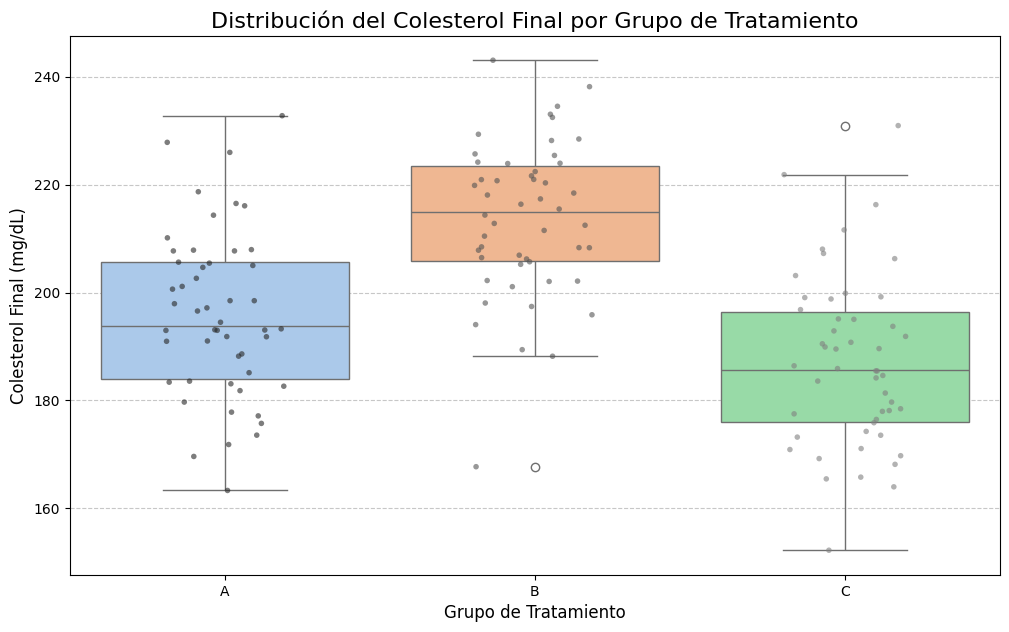

In [33]:

# Se ejecuta el código Python con la corrección
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- 0. Generación de Datos ---
np.random.seed(42)
num_pacientes_por_grupo = 50
grupos = ['A', 'B', 'C']
df = pd.DataFrame({
    'Tratamiento': np.repeat(grupos, num_pacientes_por_grupo),
})
df['Colesterol_Inicial'] = np.concatenate([
    np.random.normal(loc=220, scale=15, size=num_pacientes_por_grupo),
    np.random.normal(loc=230, scale=15, size=num_pacientes_por_grupo),
    np.random.normal(loc=215, scale=15, size=num_pacientes_por_grupo)
])
df['Colesterol_Final'] = df['Colesterol_Inicial'] - np.concatenate([
    np.random.randint(15, 30, size=num_pacientes_por_grupo),
    np.random.randint(10, 25, size=num_pacientes_por_grupo),
    np.random.randint(20, 35, size=num_pacientes_por_grupo)
])


# --- 1. Comprobación de Supuestos del ANOVA ---
print("--- Paso 1: Comprobación de Supuestos para el Colesterol Final ---")
# a) Normalidad (Test de Shapiro-Wilk)
# CORRECCIÓN: Se añade include_groups=False para silenciar la advertencia.
normality_results = df.groupby('Tratamiento').apply(lambda x: pg.normality(x['Colesterol_Final']), include_groups=False)
print("Resultados del Test de Normalidad (Shapiro-Wilk):")
print(normality_results)

# b) Homocedasticidad (Test de Levene)
homoscedasticity_results = pg.homoscedasticity(data=df, dv='Colesterol_Final', group='Tratamiento')
print("\nResultados del Test de Homocedasticidad (Levene):")
print(homoscedasticity_results)
print("\nInterpretación de supuestos: Si los p-valores ('p-val') son > 0.05, los supuestos se cumplen y el ANOVA es apropiado.")


# --- 2. Realización del Test ANOVA ---
print("\n--- Paso 2: Resultados del ANOVA para el Colesterol Final ---")
anova_results = pg.anova(dv='Colesterol_Final', between='Tratamiento', data=df, detailed=True)
print(anova_results)


# --- 3. Interpretación Detallada y Análisis Post-Hoc ---
print("\n--- Paso 3: Interpretación y Análisis Post-Hoc ---")
alpha = 0.05
p_value = anova_results['p-unc'][0]

if p_value < alpha:
    print(f"Conclusión ANOVA: Se rechaza la H0 (p-valor = {p_value:.4f}).")
    print("Existe una diferencia estadísticamente significativa en el colesterol final entre los grupos, lo que sugiere que los tratamientos tuvieron efectos diferentes.")
    print("\n--- Resultados del Test Post-Hoc (Tukey HSD) ---")
    post_hoc_results = pg.pairwise_tukey(data=df, dv='Colesterol_Final', between='Tratamiento')
    print(post_hoc_results)
    print("\nInterpretación Post-Hoc: La columna 'p-tukey' indica el p-valor para cada par. Un valor < 0.05 significa que la diferencia entre ese par de grupos es significativa.")
else:
    print(f"Conclusión ANOVA: No se puede rechazar la H0 (p-valor = {p_value:.4f}).")
    print("No hay evidencia de una diferencia significativa en el colesterol final entre los grupos de tratamiento.")


# --- 4. Visualización Mejorada ---
print("\n--- Paso 4: Visualización de la Distribución del Colesterol Final ---")
plt.figure(figsize=(12, 7))
sns.boxplot(x='Tratamiento', y='Colesterol_Final', data=df, hue='Tratamiento', palette='pastel', legend=False)
sns.stripplot(x='Tratamiento', y='Colesterol_Final', data=df, hue='Tratamiento', palette='dark:grey', jitter=0.2, size=4, alpha=0.6, legend=False)
plt.title('Distribución del Colesterol Final por Grupo de Tratamiento', fontsize=16)
plt.xlabel('Grupo de Tratamiento', fontsize=12)
plt.ylabel('Colesterol Final (mg/dL)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 🎓 De los Datos a la Conclusión: Interpretación y Redacción de Resultados

¡Felicidades! Has completado la parte computacional del análisis. Ahora comienza la fase más importante para un investigador: **darle sentido a los números y comunicar tus hallazgos** de manera clara y profesional.

Este último apartado te guiará en dos pasos clave:
1.  Interpretación profunda de los resultados obtenidos.
2.  Cómo incorporar estos resultados en la redacción de un trabajo científico.

### 1. Interpretación de los Resultados: Más Allá del P-valor

Un error común es fijarse únicamente en si el p-valor es menor de 0.05. Una interpretación robusta requiere ir más allá y conectar los resultados con la pregunta de investigación.

* **Paso 1: ¿Qué test has realizado y qué significa?**
    * **ANOVA**: Te dice si existe *alguna* diferencia significativa entre las medias de tus grupos. Si el p-valor es significativo, solo sabes que no todos los grupos son iguales, pero no sabes cuáles son diferentes.
    * **Test Post-Hoc (Tukey HSD)**: Este es el análisis de detalle. Te muestra las comparaciones par a par (Grupo A vs. B, A vs. C, etc.) y te dice exactamente dónde se encuentran las diferencias significativas.

* **Paso 2: ¿La diferencia es relevante? (Significancia estadística vs. práctica)**
    * Mira la magnitud de la diferencia en las medias (la columna `diff` o `meandiff` en los resultados post-hoc). Un p-valor muy pequeño podría estar asociado a una diferencia de medias muy pequeña y sin relevancia clínica.
    * Pregúntate: ¿Una diferencia de 2 mg/dL en el colesterol es importante en la práctica clínica, aunque sea estadísticamente significativa? El contexto de tu investigación es clave.

* **Paso 3: Sintetiza una conclusión en lenguaje claro**
    * Evita la jerga estadística. En lugar de decir "Rechazamos la hipótesis nula", traduce lo que eso significa: "Los resultados sugieren que los tratamientos tuvieron un efecto diferente en los niveles de colesterol final de los pacientes".

---
### 2. Cómo Incorporar los Resultados en tu Trabajo

En un artículo o tesis, la sección de "Resultados" debe ser objetiva y clara.

* **En el Texto**: Describe brevemente el análisis realizado y presenta los resultados estadísticos clave.
    > *Ejemplo de redacción*: "Se realizó un ANOVA de un factor para comparar el efecto de los tres tratamientos en los niveles de colesterol final. Se encontró una diferencia global estadísticamente significativa entre los grupos (F(2, 147) = 115.8, p < 0.001). Las pruebas post-hoc de Tukey HSD revelaron que el Tratamiento C (M = 182.3 mg/dL) resultó en niveles de colesterol significativamente más bajos que el Tratamiento A (M = 197.5 mg/dL, p < 0.001) y el Tratamiento B (M = 207.2 mg/dL, p < 0.001)."

* **Tablas y Figuras**:
    * Usa **tablas** para presentar resultados detallados, como la tabla de salida del test de Tukey.
    * Usa **figuras** (como los boxplots o gráficos de interacción que creaste) para ofrecer un resumen visual de los hallazgos.
    * Recuerda que cada tabla y figura debe tener un título descriptivo y ser mencionada en el texto (ej. "Como se muestra en la Figura 1...").

---
### 🤖 El Rol de la IA como Asistente: El Caso de Gemini

Herramientas como Gemini pueden ser un asistente increíblemente potente en esta fase, pero es fundamental que tú, como investigador, sigas al mando.

**¿Cómo te puede ayudar Gemini?**
* **Síntesis de Resultados**: Puedes darle los resultados numéricos de tus tests y pedirle que te ayude a redactar el párrafo para tu trabajo.
* **Clarificación de Conceptos**: Si no recuerdas qué significa un estadístico, puedes preguntarle: *"En un ANOVA, ¿qué representa el valor 'MS'?"*.
* **Formato de Tablas**: Puedes pegar la salida de texto de tus resultados y pedirle: *"Convierte esta información en una tabla en formato APA para un artículo científico."*

**⚠️ La Importancia Crítica de tu Conocimiento**

La IA es una herramienta, no un sustituto del conocimiento. **Tú eres el experto en la materia**.
* **Elección del Test**: Gemini no sabrá si los supuestos de tu ANOVA se cumplieron o si deberías haber usado un test de Kruskal-Wallis. Esa decisión, basada en la teoría, es tuya.
* **Validación del Contexto**: Gemini puede redactar que una diferencia es significativa, pero no puede juzgar si esa diferencia tiene sentido desde el punto de vista biológico o clínico. Esa interpretación crítica solo la puedes hacer tú.
* **Responsabilidad Final**: Tú eres el responsable final de la veracidad y la correcta interpretación de tu investigación. Usa la IA para acelerar procesos y pulir tu trabajo, pero confía siempre en tu conocimiento teórico como la guía principal.

#### Prompt de Ejemplo para Gemini

> "He realizado un ANOVA y un test de Tukey HSD. Los resultados del ANOVA son F=115.8 y p < 0.001. Los resultados de Tukey muestran que el grupo C es significativamente diferente de A y B, pero A y B no son diferentes entre sí. Ayúdame a redactar un párrafo conciso para la sección de 'Resultados' de mi tesis, explicando estos hallazgos."